# Code to analyze the locomotion test

In [1]:
#DEV
import os
import glob
import numpy as np
from platform import system as OS
import pandas as pd
import tables as tb
import h5py
import scipy.stats
import datetime
from scipy.ndimage.filters import gaussian_filter as smooth
from IPython.display import clear_output, display, HTML, Image
import matplotlib.cm as cm
import warnings

warnings.filterwarnings("ignore")
import sys
import pickle
import matplotlib.pyplot as plt

if OS() == 'Linux':
    root = "/data"
elif OS() == 'Windows':
    root = "C:\\DATA\\"
else:
    root = "/Users/davidrobbe/Documents/Data/"

param={
    "goalTime":7,#needed for pavel data only
    "treadmillRange":[0,90],#pavel error conversion "treadmillRange":[0,80]
    "maxTrialDuration":15,
    "interTrialDuration":10,#None pavel
    "endTrial_frontPos":30,
    "endTrial_backPos":55, 
    "endTrial_minTimeSec":4,
    "cameraSamplingRate":25, #needed for new setup    

    "sigmaSmoothPosition":0.1,#0.33, 0.18 pavel
    "sigmaSmoothSpeed":0.3,#0.3, 0.5 pavel
    "nbJumpMax":100,#200 pavel
    "binSize":0.25,
    #parameters used to preprocess (will override the default parameters)
}  
ThisNoteBookPath=os.path.dirname(os.path.realpath("__file__"))
CommonNoteBookesPath=os.path.join(os.path.split(ThisNoteBookPath)[0],"load_preprocess_rat")
CWD=os.getcwd()
os.chdir(CommonNoteBookesPath)
%run Animal_Tags.ipynb
%run UtilityTools.ipynb
%run BatchRatBehavior.ipynb
%run plotRat_documentation_3_KinematicsInvestigation.ipynb
%run plotRat_documentation_1_GeneralBehavior.ipynb
%run loadRat_documentation.ipynb
%run RunBatchRat_3_CompareGroups.ipynb
%run Lesion_Size.ipynb

os.chdir(CWD)

print('Done!')

Done!


#### ViewPoint intertrial analysis for Loco test

check normal exploration

In [2]:

def find_persistent_movement_epochs(pos: np.array, TrdSpeed: int, fs: int):
    """
    this function finds epochs in the position of a single trial, pos, where the animal has moved
    for a duration of at least, TH*cameraSamplingRate
    pos: position as a np.array
    """
    SpeedTolerance = 5 if TrdSpeed==0 else 10
    DurationTolerance= 0.4*fs
    
    pos_=smooth(pos,.3*fs,mode="nearest")
    velocity=np.append(TrdSpeed-(np.diff(pos_)*fs),TrdSpeed)
    
    zeroVel=np.logical_and(velocity<SpeedTolerance, velocity>-SpeedTolerance)
    
    movement= np.logical_not(zeroVel)
    movement=movement*1

    dpcross=np.absolute( np.append(movement,0) - np.append(0,movement) )
#     breakpoint()
    #any 1 in dpcross mean a zero-crossing in diff(pos)
    crossindex=np.where(dpcross)[0]
    crossindex=np.reshape(crossindex,(-1,2))
    movementepoch=crossindex[crossindex[:,1]-crossindex[:,0] > DurationTolerance]
    return movementepoch

def run_distance(data,trial=None):
    if trial is None:
        trial=list(data.position.keys())
    elif not hasattr(trial,'__iter__'):
        trial=[trial]
    
    assert data.dataType == 'ViewPoint'
    
    dis=[0]
    for i in trial:
        if i < 10:
            continue #first 10 session with short trial
        allTraj=data.position[i]
        treadmillStep=np.expand_dims(data.treadmillSpeed[i]/data.cameraSamplingRate,1)
        posMoveIndex=find_persistent_movement_epochs(allTraj,
                                                     TrdSpeed=data.treadmillSpeed[i],
                                                     fs=data.cameraSamplingRate)

        for i,j in posMoveIndex:
            epochPos=allTraj[int(i):int(j)]
            dis[-1]+=np.nansum(np.absolute(np.diff(epochPos)-treadmillStep))
        dis.append(0)

    return np.array(dis[:-1])

def intertrial_displacement(data,trial=None):
    if trial is None:
        trial=list(data.rawIntertrialPosition.keys())
    elif not hasattr(trial,'__iter__'):
        trial=[trial]
    
    dis=[0]
    for i in trial:
        if data.dataType != 'ViewPoint':
            allTraj= data.position[i][int((-data.interTrialDuration[i]+1)*data.cameraSamplingRate):]
            TH=int(0.6*data.cameraSamplingRate)
            data.cameraSamplingRateInterTrial=data.cameraSamplingRate
        else:
            allTraj=smooth(data.rawIntertrialPosition[i],.3*data.cameraSamplingRateInterTrial)
            TH=int(0.6*data.cameraSamplingRateInterTrial)
            

        posMoveIndex=find_persistent_movement_epochs(allTraj,
                                                     TrdSpeed=0,
                                                     fs=data.cameraSamplingRateInterTrial
                                                     )

        for i,j in posMoveIndex:
            epochPos=allTraj[int(i):int(j)]
            dis[-1]+=np.nansum(np.absolute(np.diff(epochPos)))
        dis.append(0)

    return np.array(dis[:-1])

In [46]:
def intertrial_max_velocity(data,sigmaSpeed=0.3):
    
    cs=data.cameraSamplingRateInterTrial
    tr=0
    
    vel=[]
    for i,pos in data.rawIntertrialPosition.items():
        speed= tr - np.diff(pos)*cs 
        speed=smooth(speed,sigmaSpeed*cs)
        vel.append(np.nanmax(np.absolute(np.append(speed,np.nan))))
    
    return np.array(vel)


def trial_max_velocity(data,sigmaSpeed=0.3):
    cs=data.cameraSamplingRate
    
    vel=np.ones((list(data.position.keys())[-1]+1,))
    for i,pos in data.position.items():
        tr=data.treadmillSpeed[i]
        speed= tr - np.diff(pos)*cs 
        speed=smooth(speed,sigmaSpeed*cs)
        vel[i]=np.nanmax(np.absolute(np.append(speed,np.nan)))
    
    return vel

def trial_max_acceleration(data,sigmaSpeed=0.3):
    cs=data.cameraSamplingRate
    
    acc=np.ones((list(data.position.keys())[-1]+1,))
    for i,pos in data.position.items():
        tr=data.treadmillSpeed[i]
        speed= tr - np.diff(pos)*cs 
        speed=smooth(speed,sigmaSpeed*cs)
        accelaration=np.diff(speed)*cs
        acc[i]=np.nanmax(np.absolute(np.append(accelaration,np.nan)))
    
    return acc

In [47]:
def time_in_back(data):    
    assert data.dataType == 'ViewPoint'
    cs=data.cameraSamplingRate
    t=[]
    for i in data.position.keys():
        if i < 10:
            continue #first 10 session with short trial
        traj=data.position[i]
        t.append(np.sum(traj>75)/cs)

    return np.array(t)

def position_variability(data):
    assert data.dataType == 'ViewPoint'
    cs=data.cameraSamplingRate
    t=[]
    for i in data.position.keys():
        if i < 10:
            continue #first 10 session with short trial
        traj=data.position[i]
        t.append(np.std(traj))

    return np.array(t)


In [48]:
LesionAnimalList=['Rat325', 'Rat337', 'Rat341', 'Rat345', 'Rat365', 'Rat366', 'Rat372']#, 'Rat329', 'Rat333']
NormalAnimalList=['Rat359','Rat360','Rat361','Rat356','Rat357','Rat358','Rat373','Rat349', 'Rat368','Rat367','Rat371']

profile={'Type':'Good',
         'rewardType':'Progressive',
#          'initialSpeed':'10',
#          'Speed':['10'],
         'Tag':['Reverse-Late_DLS-EXP','Early-Lesion_DMS-EXP','Early-Lesion_DS-EXP','Late-Lesion_DLS-EXP',
                'Control-EXP','ImmobileTreadmill-EXP']
         }

sessionList0=batch_get_session_list(root,NormalAnimalList,profile)['Sessions']
sessionList1=batch_get_session_list(root,LesionAnimalList,profile)['Sessions']

disIT0=np.ones((45,len(sessionList0)))*np.nan
disIT1=np.ones((45,len(sessionList1)))*np.nan

dis0=np.ones((45,len(sessionList0)))*np.nan
dis1=np.ones((45,len(sessionList1)))*np.nan

NbTrial0=np.ones((len(sessionList0),))*np.nan
NbTrial1=np.ones((len(sessionList1),))*np.nan

velIT0=np.ones((45,len(sessionList0)))*np.nan
velIT1=np.ones((45,len(sessionList1)))*np.nan

vel0=np.ones((45,len(sessionList0)))*np.nan
vel1=np.ones((45,len(sessionList1)))*np.nan

acc0=np.ones((45,len(sessionList0)))*np.nan
acc1=np.ones((45,len(sessionList1)))*np.nan


Ftime0=np.ones((45,len(sessionList0)))*np.nan
Ftime1=np.ones((45,len(sessionList1)))*np.nan

posSD0=np.ones((45,len(sessionList0)))*np.nan
posSD1=np.ones((45,len(sessionList1)))*np.nan



for i,session in enumerate(sessionList0):
    animal=session[:6]
    data=Data(root,session[:6],session,param=param,redoPreprocess=False, saveAsPickle=False);
    tmp=intertrial_displacement(data)
    disIT0[:len(tmp),i]=tmp
    tmp=run_distance(data)
    dis0[:len(tmp),i]=tmp
    tmp=intertrial_max_velocity(data)
    velIT0[:len(tmp),i]=tmp
    tmp=trial_max_velocity(data)
    vel0[:len(tmp),i]=tmp
    tmp=time_in_back(data)
    Ftime0[:len(tmp),i]=tmp
    tmp=position_variability(data)
    posSD0[:len(tmp),i]=tmp
    tmp=trial_max_acceleration(data)
    acc0[:len(tmp),i]=tmp

    

    
    NbTrial0[i]=data.nTrial

for i,session in enumerate(sessionList1):
    animal=session[:6]
    data=Data(root,session[:6],session,param=param,redoPreprocess=False, saveAsPickle=False);
    tmp=intertrial_displacement(data)
    disIT1[:len(tmp),i]=tmp
    tmp=run_distance(data)
    dis1[:len(tmp),i]=tmp
    tmp=intertrial_max_velocity(data)
    velIT1[:len(tmp),i]=tmp
    tmp=trial_max_velocity(data)
    vel1[:len(tmp),i]=tmp
    tmp=time_in_back(data)
    Ftime1[:len(tmp),i]=tmp
    tmp=position_variability(data)
    posSD1[:len(tmp),i]=tmp
    tmp=trial_max_acceleration(data)
    acc1[:len(tmp),i]=tmp



    NbTrial1[i]=data.nTrial


# Position variability during Trials

In [39]:
a=posSD0[:,:]
b=posSD1[:,:]

perm=permtest(a.T,b.T,nIterations=10000)

perm.pVal

array([0.8636, 0.0056, 0.7526, 0.7048, 0.0566, 0.199 , 0.8712, 0.0326,
       0.4148, 0.258 , 0.1252, 0.0526, 0.2542, 0.0776, 0.6046, 0.2306,
       0.1282, 0.352 , 0.8736, 0.5646, 0.214 , 0.906 , 0.5408, 0.6476,
       0.7002, 0.1344, 0.4518, 0.6112, 0.4284, 0.6224, 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    ])

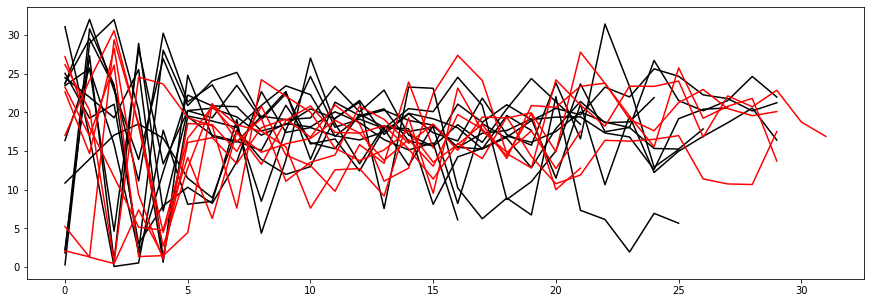

In [43]:
plt.figure(figsize=(15,5))
plt.plot(posSD0,'k');
plt.plot(posSD1,'r');

# Time in the back

In [32]:
a=Ftime0[:,:]
b=Ftime1[:,:]

perm=permtest(a.T,b.T,nIterations=10000)

perm.pVal

array([0.    , 0.9008, 0.721 , 0.4702, 0.494 , 0.8196, 0.9702, 0.283 ,
       0.2292, 0.877 , 0.6134, 0.2332, 0.1752, 0.948 , 0.8988, 0.4754,
       0.811 , 0.4162, 0.7078, 0.5274, 0.4566, 0.4034, 0.4276, 0.5878,
       0.4824, 0.8264, 0.4504, 0.7292, 0.9898, 0.7506, 0.355 , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    ])

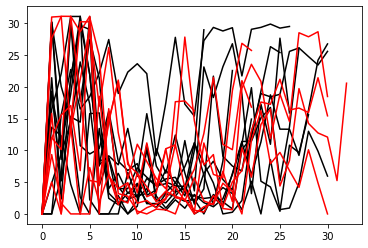

In [33]:
plt.plot(Ftime0,'k');
plt.plot(Ftime1,'r');

# Displacement

In [8]:
a=disIT0[:,:]
b=disIT1[:,:]

perm=permtest(a.T,b.T,nIterations=10000)

perm.pVal

array([0.9186, 0.5874, 0.2062, 0.5042, 0.8638, 0.784 , 0.7046, 0.6216,
       0.8728, 0.3288, 0.658 , 0.8   , 0.9902, 0.8076, 0.7106, 0.559 ,
       0.659 , 0.8532, 0.01  , 0.1204, 0.1444, 0.4868, 0.2832, 0.7756,
       0.2438, 0.184 , 0.5636, 0.7576, 0.936 , 0.1064, 0.4004, 0.5106,
       0.072 , 0.5416, 0.7012, 0.6556, 0.8054, 0.4806, 0.6774, 0.3238,
       0.    , 0.    , 0.    , 0.    , 0.    ])

In [9]:
a=dis0[:,:]
b=dis1[:,:]

perm=permtest(a.T,b.T,nIterations=10000)

perm.pVal

array([0.903 , 0.452 , 0.603 , 0.8324, 0.0508, 0.2664, 0.461 , 0.0714,
       0.4392, 0.4446, 0.6052, 0.4146, 0.2124, 0.1406, 0.2864, 0.0404,
       0.3732, 0.2002, 0.5848, 0.5974, 0.4996, 0.469 , 0.8498, 0.621 ,
       0.3256, 0.9394, 0.834 , 0.4228, 0.955 , 0.613 , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    , 0.    , 0.    , 0.    ])

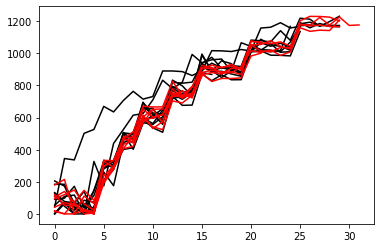

In [28]:
plt.plot(dis0,'k');
plt.plot(dis1,'r');

Checking whether groups differ in their max trial number

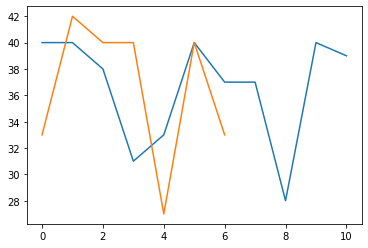

In [11]:
plt.plot(NbTrial0)
plt.plot(NbTrial1)
plt.show()

In [12]:
perm=permtest(NbTrial0,NbTrial1,nIterations=10000)

perm.pVal

array([0.8726])

#  velocity

In [24]:
#INTERTRIALS
a=velIT0[:,:]
b=velIT1[:,:]

perm=permtest(a.T,b.T,nIterations=10000)

perm.pVal

array([0.1296, 0.011 , 0.1808, 0.224 , 0.1878, 0.2606, 0.5444, 0.1936,
       0.2414, 0.1126, 0.6526, 0.5936, 0.1708, 0.9504, 0.9404, 0.8066,
       0.3898, 0.6526, 0.1998, 0.0724, 0.2018, 0.3952, 0.4244, 0.0844,
       0.5538, 0.4658, 0.6644, 0.5644, 0.8608, 0.1102, 0.8848, 0.8326,
       0.2308, 0.5516, 0.76  , 0.4248, 0.419 , 0.236 , 0.2216, 0.5132,
       0.    , 0.    , 0.    , 0.    , 0.    ])

In [25]:
#TRIALS
a=vel0[:,:]
b=vel1[:,:]

perm=permtest(a.T,b.T,nIterations=10000)

perm.pVal

array([0.5218, 0.724 , 0.377 , 0.8608, 0.3384, 0.413 , 0.4724, 0.419 ,
       0.9406, 0.5018, 0.5752, 0.2752, 0.2196, 0.9304, 0.2968, 0.28  ,
       0.306 , 0.3092, 0.3668, 0.2314, 0.7522, 0.0024, 0.0448, 0.7024,
       0.934 , 0.3908, 0.0836, 0.6254, 0.8174, 0.1236, 0.2088, 0.2   ,
       0.9644, 0.6918, 0.4694, 0.4166, 0.7788, 0.6862, 0.7366, 0.2248,
       0.    , 0.    , 0.    , 0.    , 0.    ])

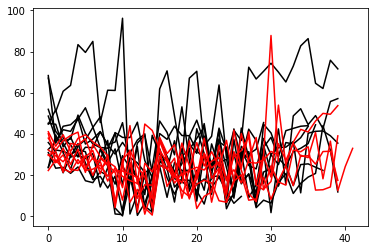

In [51]:
plt.plot(velIT0,'k');
plt.plot(velIT1,'r');

# Max Trial Accelaration

In [49]:
#TRIALS
a=acc0[:,:]
b=acc1[:,:]

perm=permtest(a.T,b.T,nIterations=10000)

perm.pVal

array([0.4592, 0.622 , 0.3898, 0.4438, 0.6676, 0.3992, 0.86  , 0.7706,
       0.844 , 0.4666, 0.4562, 0.3742, 0.176 , 0.631 , 0.9806, 0.298 ,
       0.1284, 0.3288, 0.6636, 0.3158, 0.2176, 0.259 , 0.518 , 0.2022,
       0.9366, 0.8786, 0.3168, 0.2158, 0.4842, 0.1496, 0.6654, 0.0046,
       0.3844, 0.94  , 0.709 , 0.6194, 0.4912, 0.5814, 0.2666, 0.9818,
       0.    , 0.    , 0.    , 0.    , 0.    ])

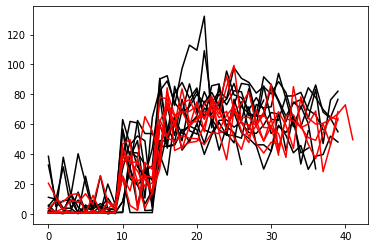

In [50]:
plt.plot(acc0,'k');
plt.plot(acc1,'r');

# Weight Comparison

In [ ]:
CtrlW   =dict.fromkeys(NormalAnimalList,np.nan)
LesionW =dict.fromkeys(LesionAnimalList,np.nan)
Weights=dict()

### Data From Mostafa's Lab Book

In [ ]:
Weights['Rat367']=560
Weights['Rat368']=500
Weights['Rat372']=435
Weights['Rat366']=450
Weights['Rat371']=425
Weights['Rat369']=505
Weights['Rat365']=500
Weights['Rat349']=440
Weights['Rat373']=380
Weights['Rat358']=490
Weights['Rat357']=445
Weights['Rat356']=450
Weights['Rat361']=440
Weights['Rat360']=460
Weights['Rat359']=475
Weights['Rat364']=335
Weights['Rat363']=385
Weights['Rat362']=420
Weights['Rat355']=400
Weights['Rat354']=340
Weights['Rat353']=385

In [ ]:
for animal,w in Weights.items():
    if animal in CtrlW:
        CtrlW.update({animal:w})
    elif animal in LesionW:
        LesionW.update({animal:w})
        
print(CtrlW,'\n',LesionW)

---
---
---
------
---
---
---

In [ ]:
session='Rat345_2019_06_05_10_02'
data=Data(root,session[:6],session,param=param,redoPreprocess=False, saveAsPickle=False);
it=intertrial_displacement(data);

In [ ]:
for i,pos in data.rawIntertrialPosition.items():
    plt.plot(pos)
    plt.title(f'trial {i}, speed {data.treadmillSpeed[i]}, DIS={it[i]}')
    plt.ylim([0,90])
    plt.show()
    breakpoint()
    clear_output()
    